In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.decomposition import PCA

from sklearn.feature_selection import VarianceThreshold, SelectFromModel, RFECV, SequentialFeatureSelector

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import accuracy_score

from sklearn.datasets import make_classification, load_wine, load_breast_cancer, load_diabetes, load_digits

In [2]:
plt.style.use('seaborn-darkgrid')

In [3]:
def plot_scatter(x, y, auto_scaled=True, title=None, clusters=None):
    plt.figure(figsize=(4, 4))
    plt.scatter(x, y, c=clusters, cmap='bwr')
    
    if not auto_scaled:
        plt.axis('square')
    
    plt.grid(True)
    plt.title(title)
    
    plt.show()
    
def return_X_y(data, target_column):
    return data.drop(target_column, axis=1), data[target_column]

In [4]:
wine_sklearn = load_wine(as_frame=True)
wine_data, wine_labels = wine_sklearn['data'], wine_sklearn['target']

# Homework

## Exercise  1 - Scaling (2 points)

Perform standardization for wine dataset (`wine_data`) using only basic python, numpy and pandas (without using `StandardScaler` and sklearn at all). Implementation of function (or class) that can get dataset as input and return standardized dataset as output is preferrable, but not necessary.

Compare you results (output) with `StandardScaler`.

**NOTE:**

- 1 point for functional version, 2 points for implementing scaling as sklearn pipeline compartible class. 
- Maximum for the exercise is 2 points.


### Simple version (1 point)

In [5]:
# 1 point
def scale(X):
    def scaler(x): return (x - np.mean(x)) / np.std(x)
    return scaler(X)

In [6]:
assert np.allclose(np.array(scale(wine_data)), StandardScaler().fit_transform(wine_data))

### Pipeline Version (2 points)

In [7]:
# 2 points
from sklearn.base import BaseEstimator, TransformerMixin

class CustomScaler(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, copy=True, with_mean=True, with_std=True):
        self.columns = columns
        self.copy = copy
        self.with_mean = with_mean
        self.with_std = with_std

    def fit(self, X, y=None):

        self.means = np.zeros(X.shape[1]) if not self.with_mean else [
            np.mean(X[col]) for col in X.columns]
        self.stds = np.ones(X.shape[1]) if not self.with_std else [
            np.std(X[col]) for col in X.columns]
        if y:
            self.mean_y = np.mean(y)
            self.std_y = np.std(y)
        return self

    def transform(self, X, y=None, copy=None):
        X = X[self.columns] if self.columns else X
        if not y:
            return (X - self.means) / self.stds if not copy else (X.copy() - self.means) / self.stds
        else:
            return (X - self.means) / self.stds if not copy else (X.copy() - self.means) / self.stds, \
                (y - self.mean_y) / self.std_y if not copy else (y.copy() -
                                                                 self.mean_y) / self.std_y if y else None


In [8]:
assert np.allclose(CustomScaler().fit_transform(wine_data), StandardScaler().fit_transform(wine_data))

## Exercise  2 - Visualization (3 points)

As noted earlier, standardization/normalization of data can be crucial for some distance-based ML methods.

Let's generate some toy example of unnormalized data and visualize the importance of this process once more:

In [9]:
feature_0 = np.random.randn(1000) * 10   
feature_1 = np.concatenate([np.random.randn(500), np.random.randn(500) + 5])
data = np.column_stack([feature_0, feature_1])
data 

array([[13.54943168, -0.1170601 ],
       [21.92481466,  1.30684157],
       [ 2.56772902, -1.50798273],
       ...,
       [ 8.4383612 ,  5.54506645],
       [-3.34790329,  5.07373131],
       [-4.42497494,  4.68231564]])

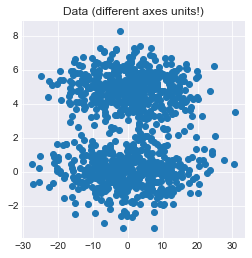

In [10]:
plot_scatter(data[:, 0], data[:, 1], auto_scaled=True, title='Data (different axes units!)')

**NOTE:** on the plot above axes are scaled differently and we can clearly see two potential *classes/clusters*. In fact `matplotlib` performed `autoscaling` (which is basically can be considered as `MinMaxScaling` of original data) just for better visualization purposes.

Let's turn this feature off and visualize the original data on the plot with equally scaled axes:

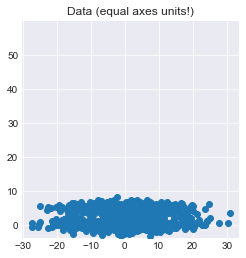

In [11]:
plot_scatter(data[:, 0], data[:, 1], auto_scaled=False , title='Data (equal axes units!)')

This picture is clearly less interpretable, but much closer to "how distance-based algorithm see the original data": separability of data is hardly noticable only because the variation (std) of x-feature is much bigger in absolute numbers.

Perform `StandardScaling` and `MinMaxScaling` of original data; visualize results for each case (**use `plot_scatter` with `auto_scaled=False`**):

### MinMaxScaling (0.5 point)

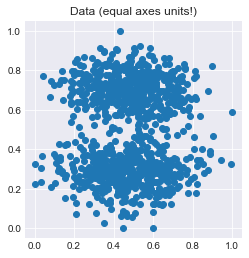

In [12]:
data_minmax = MinMaxScaler().fit_transform(data.copy())
plot_scatter(data_minmax[:, 0], data_minmax[:, 1], auto_scaled=False , title='Data (equal axes units!)')

On the graph, we see a similar result to the one shown when drawing the graph with the auto_scale=True parameter. As indicated, the matplotlib scaler similar to MinMaxScaler is used. Thus, we see 2 potential classes/clusters on the graph.

### StandardScaler (0.5 point)

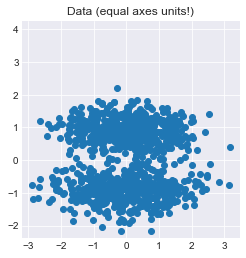

In [13]:
data_scaler = StandardScaler().fit_transform(data.copy())
plot_scatter(data_scaler[:, 0], data_scaler[:, 1], auto_scaled=False , title='Data (equal axes units!)')

There is a similar situation with StandardScaler. We also see 2 potential classes/clusters on the graph. 

### (Bonus) K-means (2 points)

Illustrate the impact of scaling on basic distance-based clustering algorithm [K-means](https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1) using `data` generated above.

**NOTE:** basically, you don't need understanding K-means algorithm here, you just need to:

1) run algorithm (with k=2, k - number of clusters/classes) on unscaled data    
2) run algorithm (with k=2) on scaled data    
3) plot results: highlight different clusters using different colors.

You can use this [question](https://stats.stackexchange.com/questions/89809/is-it-important-to-scale-data-before-clustering/89813) as a hint, but I recommend you to plot results using `plot_scatter` with `equal_scaled=True`: it might help you to intuitively understand the reasons of such scaling impact.


In [14]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=2)
clusters = km.fit_predict(data)

km.cluster_centers_

array([[-7.70240479,  2.2022695 ],
       [ 7.72751041,  2.63849931]])

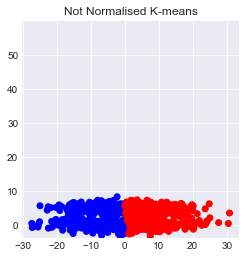

In [15]:
plot_scatter(data[ : , 0], data[ : , 1], auto_scaled=False , title='Not Normalised K-means', clusters=clusters)

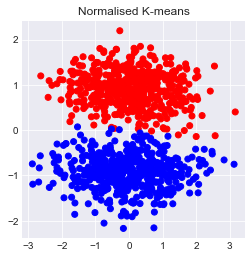

In [16]:
clusters = km.fit_predict(data_scaler)
plot_scatter(data_scaler[ : , 0], data_scaler[ : , 1], title='Normalised K-means', clusters=clusters)

If we compare the above graphs, in the case of non-normalized data we see that k-means was not able to divide the data into clusters properly. In the case of normalized data the situation is much more optimistic. 

The k-means minimizes the error function using a gradient-based optimization algorithm. Normalizing the data improves convergence of such algorithms. If different features have different scales, then derivatives tend to align along directions with higher variance, which leads to bad convergence.

## Exercise  3 - Preprocessing Pipeline (2 points)

In [17]:
wine_train, wine_val, wine_labels_train, wine_labels_val = train_test_split(wine_data, wine_labels, 
                                                                            test_size=0.3, random_state=42)

Train model (for example, `LogisticRegression(solver='liblinear', penalty='l1')` on raw `wine_train` data; then train same model after data scaling; then add feature selection (and train model again on scaled data). For each experiment all required preprocessing steps (if any) should be wrapped into sklearn pipeline.

Measure `accuracy` of all 3 approaches on `wine_val` dataset. Describe and explain results.

In [18]:
from sklearn.metrics import accuracy_score

clf = LogisticRegression(solver='liblinear', penalty='l1')
clf.fit(wine_train, wine_labels_train)

print('Model score (val):', accuracy_score(wine_labels_val, clf.predict(wine_val))) 
print('Model score (test):', accuracy_score(wine_labels_train, clf.predict(wine_train))) 
print('Model coefs')
pd.DataFrame(clf.coef_, columns=wine_train.columns)

Model score (val): 0.9814814814814815
Model score (test): 0.967741935483871
Model coefs


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,-0.228226,0.354199,0.377359,-0.519449,-0.043888,0.0,2.145920,0.0,0.000000,0.000000,0.0,0.000000,0.013633
1,0.828862,-0.946575,0.000000,0.240290,0.003693,0.0,0.433418,0.0,0.820539,-1.954681,0.0,0.059549,-0.011445
2,0.000000,0.258135,0.000000,0.056988,0.006848,0.0,-2.812252,0.0,0.000000,0.932990,0.0,-1.693077,-0.000502


As we can see, even without scaling, good results were obtained for the validation dataset and slightly worse results for the training dataset. Yes to some signs we observe zeroed out coefficients for all labels: total_phenols, nonflavanoid_phenols, hue. 

### Fitting scaled data

In [19]:
pipe_scale = Pipeline(steps=[('scaler', MinMaxScaler()),  ('logistic_regession', clf)])
pipe_scale.fit(wine_train, wine_labels_train)

print('Model score (val):', accuracy_score(wine_labels_val, pipe_scale.predict(wine_val)))
print('Model score (val):', accuracy_score(wine_labels_train, pipe_scale.predict(wine_train))) 

print('Model coefs')
pd.DataFrame(pipe_scale['logistic_regession'].coef_, columns=wine_train.columns)


Model score (val): 1.0
Model score (val): 0.967741935483871
Model coefs


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,1.786132,0.000000,0.0,-3.334399,0.0,0.0,3.148926,0.0,0.000000,0.000000,0.000000,0.994038,5.881539
1,-3.385510,0.000000,0.0,0.444078,0.0,0.0,0.000000,0.0,0.330888,-5.700067,2.717728,0.576216,-4.132819
2,0.000000,1.701258,0.0,0.000000,0.0,0.0,-4.050720,0.0,0.000000,3.972009,0.000000,-5.305990,0.000000


For the validation dataset, we got the same score as for the non-scaled data. In the case of the training set, the accuracy of the model was 100%. Among the zeroed coefficients there are other features: magnesium, total_phenols, nonflavanoid_phenols.

### Feature Selection

In [20]:
pca = PCA()

pipe_scale_pca = Pipeline(steps=[('scaler', MinMaxScaler(
)), ('pca', PCA()), ('logistic_regession', clf)])
pipe_scale_pca.fit(wine_train, wine_labels_train)

print('Model score:', accuracy_score(
    wine_labels_val, pipe_scale_pca.predict(wine_val)))
print('Model score:', accuracy_score(
    wine_labels_train, pipe_scale_pca.predict(wine_train)))
    
print('Model coefs')
pd.DataFrame(pipe_scale_pca['logistic_regession'].coef_, columns=wine_train.columns)

Model score: 1.0
Model score: 0.9596774193548387
Model coefs


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,-5.609281,-5.633160,0.0,0.0,-0.418154,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,12.113996,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6.116389,-4.000478,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In the latter case, we observe a similar exact model for the validation dataset, for the training dataset the result is slightly worse than it was. 

The main problem when applying regularization to unscaled data is the problem of interpreting model coefficients. Thus, in cases 1 and 2 we observe different zeroed coefficients. 

## Exercise 4 - manual PCA (5 points)
The task is to solve PCA as an optimization problem, without explicitly doing eigen value decomposition.
In the most general setting PCA is minimization of reconstruction error of a projection of given rank $q$

$$\min_{\mu, \lambda_1,\ldots, \lambda_n, \mathbf{V}_q} \sum_{i=1}^n ||x_i - \mu - \mathbf{V}_q \lambda_i||^2$$

With a number of steps that can be found here https://stats.stackexchange.com/a/10260 this task transforms to
 $$\max_{u_i} \sum_{i=1}^q u_i^T \mathbf{S} u_i$$
 where $\mathbf{S}$ is the sample covariance matrix (after standartization) and $u_1, \ldots, u_q$ are the $q$ are orthonormal columns in $\mathbf{V}_q$.
 Let us solve this optimization problem with `scipy.optimize` library.
 
 Additional 2 point are given for visualization of the results.

### PCA (3 points)

In [21]:
wine_data, wine_labels = wine_sklearn['data'], wine_sklearn['target']

Find a covariance matrix of standartized data and assing it to S.

In [22]:
wine_data_scaled = StandardScaler().fit_transform(wine_data)
S = np.cov(wine_data_scaled.T)

If your code is correct, the following assert should be Ok.

In [23]:
assert np.allclose(np.linalg.norm(S), 5.787241159764733)

In [24]:
x0=10 * np.random.random(wine_data_scaled.shape[1])
x0

array([2.31081845, 4.16532053, 7.13005027, 3.44917989, 6.72408782,
       0.11807205, 5.96876084, 3.28900373, 0.97903679, 5.81210063,
       7.02709998, 9.47863228, 1.72565568])

In [25]:
from scipy.optimize import minimize


def objective(x):
    return -x@S@x


def norm_constraint(x):
    return x@x - 1


con1 = {'type': 'eq', 'fun': norm_constraint}

x0 = np.random.random(wine_data_scaled.shape[1])

sol = minimize(objective,
               x0,
               constraints=[con1]
               )
x0 = sol.x


In [26]:
x0

array([ 0.14431931, -0.24522527, -0.00204451, -0.23933623,  0.14201755,
        0.39468079,  0.42293491, -0.29847914,  0.31346991, -0.08859328,
        0.29670883,  0.37615319,  0.28671492])

Hurray! We have first vector! Let's do another one.

In [27]:
def orthogonality_constraint(x):
    return x@x0

con2 = {'type': 'eq', 'fun': orthogonality_constraint}

x1 = np.random.random(wine_data_scaled.shape[1])

sol = minimize(objective,
               x1,
               constraints =  [con1, con2]
               )

x1 = sol.x

In [28]:
x1

array([ 0.48364481,  0.22492968,  0.31606957, -0.01059255,  0.29963512,
        0.06504084, -0.00336063,  0.02878186,  0.03929964,  0.52999541,
       -0.27924437, -0.16449645,  0.3649039 ])

If your solution is correct, the following asserts should be Ok.

In [29]:
assert np.allclose(x0@S@x0, 4.732436977583595)
assert np.allclose(x1@S@x1, 2.5110809296451233)

### Visualization (2 points)

Visualize the points after applying custom dimension reduction with 2 components.

Fisrt, with given principal components we can find final representation of the data.

In [44]:
projection_pc_first  = wine_data_scaled.dot(x0.T)
projection_pc_second = wine_data_scaled.dot(x1.T)

final_dataset = pd.DataFrame({'PC_1': projection_pc_first, 'PC_2': projection_pc_second, 'target': wine_labels})
final_dataset.head(10)

,PC_1,PC_2,target
0,3.316796,1.443451,0
1,2.209400,-0.333393,0
2,2.516769,1.031144,0
3,3.757067,2.756367,0
4,1.008965,0.869827,0
5,3.050279,2.122393,0
6,2.449031,1.174838,0
7,2.059359,1.608956,0
8,2.510863,0.918053,0
9,2.753608,0.789429,0


Now, we are going to visualize the data as 1-dimentional and 2-dimentional plots.

C:\Users\vict1\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\vict1\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'2-dimentional data with first ans second PC'}, xlabel='PC_2', ylabel='PC_1'>

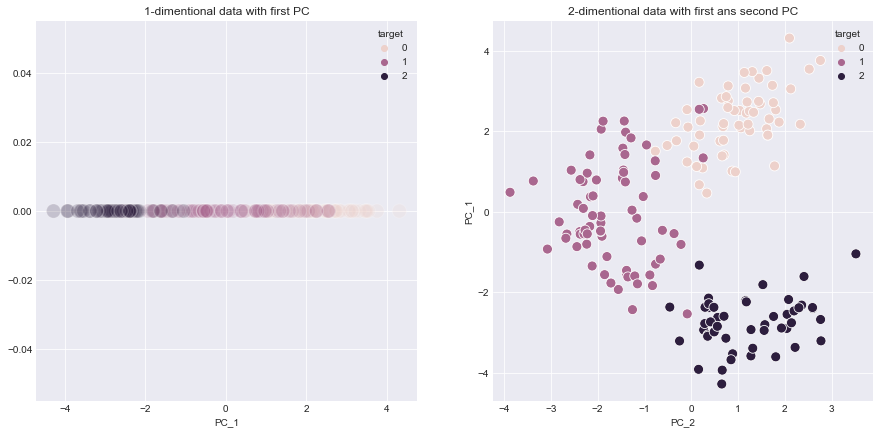

In [56]:
f, ax = plt.subplots(1, 2, figsize=(15, 7))

ax[0].set_title('1-dimentional data with first PC')
sns.scatterplot(final_dataset['PC_1'], [0] * final_dataset.shape[0], hue=final_dataset['target'], s=200, ax=ax[0], alpha=0.2)

ax[1].set_title('2-dimentional data with first ans second PC')
sns.scatterplot(final_dataset['PC_2'], final_dataset['PC_1'], hue=final_dataset['target'], s=100, ax=ax[1])

On the first plot we clearly see, that label **2** is quite separated from groups **0** and **1**. It is still possible to classify label, but for groups **0** and **1** it will be quite complicated. 

If we add second principal component (second plot), we can clearly see clusters on the plot.

Actually, PCA allows to reduce dimentions without lossing much information about the data. We reduced dimention to 2 vectors and it's still possible to classify or cluster labels with the help only 1-st and 2-nd principal components.

## Exercise 5 - Boruta (3 points)

Let us classify handwritten digits 0, 1 and 2. 
To make task not so easy the images are binarized (no shadows of gray present) as it happens with xerocopied documents.

Let us also find out to which parts of an image there's no need to look in order to clasify three digits of interest.

In [32]:
X, y = load_digits(n_class=3, return_X_y=True, as_frame=True)
X = (X > 10).astype(int)


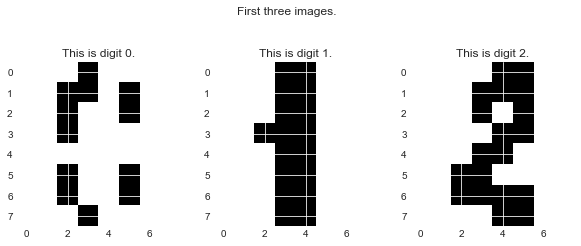

In [33]:
f, ax = plt.subplots(1, 3, figsize=(10, 4))
for i in range(3):
    ax[i].imshow(X.iloc[i].values.reshape(8, 8))
    ax[i].set_title(f"This is digit {y[i]}.")
plt.suptitle("First three images.")
plt.show()


Split data into train and test, let test size be 30% of the dataset and fix random state to 42:

In [34]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [35]:
assert y_val.shape[0] == 162
assert y_val.sum() == 169

Fit a RandomForestClassifier with max_depth=13 and evaluate it's performance:

In [36]:
clf = RandomForestClassifier(max_depth=13)
clf.fit(X_train, y_train)
acc = accuracy_score(y_val, clf.predict(X_val))
print(acc)

0.9876543209876543


In [37]:
assert acc > 0.98

Now we will use Boruta to find redundand pixels. If the package is not installed in your system, uncomment and run the following cell.

In [38]:
from boruta import BorutaPy

feat_selector = BorutaPy(RandomForestClassifier(max_depth=13), 
                         n_estimators='auto', 
                         verbose=0, 
                         max_iter=100,
                         random_state=42)

feat_selector.fit(np.array(X_train), np.array(y_train))

BorutaPy(estimator=RandomForestClassifier(max_depth=13, n_estimators=62,
                                          random_state=RandomState(MT19937) at 0x2004A0F1C40),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x2004A0F1C40)

In [39]:
print('Initial number of features:', X_train.shape[1])
print('Number of important features: ', feat_selector.n_features_) 

Initial number of features: 64
Number of important features:  31


As we can see, the algorithm has halved the number of features.

Let us print redundant pixels as a mask. Does the result looks similar to mine (or to Among us chracters)? 

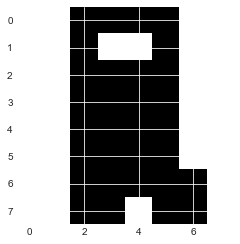

In [40]:
mask = np.array(feat_selector.support_).reshape(8,8)
plt.imshow(mask)

At the end let us redo  classification but only with selected features

In [41]:
X_train_new = feat_selector.transform(np.array(X_train))
X_val_new = feat_selector.transform(np.array(X_val)) 

In [42]:
clf = RandomForestClassifier(max_depth=13)
clf.fit(X_train_new, y_train)
acc = accuracy_score(y_val, clf.predict(X_val_new))
print(acc)

0.9938271604938271


In [43]:
assert acc > 0.99

# Materials & References

1. General article about feature engineering and selection (main reference):
https://github.com/Yorko/mlcourse.ai/blob/master/jupyter_english/topic06_features_regression/topic6_feature_engineering_feature_selection.ipynb

2. Feature engineering/preprocessing, using scikit-learn API (great code examples, but really brief explanation):    
https://scikit-learn.org/stable/modules/preprocessing

3. Feature scaling/normalization:     
https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35

4. Log Transform/power transform:    
https://medium.com/@kyawsawhtoon/log-transformation-purpose-and-interpretation-9444b4b049c9

6. Missing values preprocessing using scikit-learn API (great code examples, great explanation):    
https://scikit-learn.org/stable/modules/impute.html

7. Feature selection scikit-learn API (great code examples, great explanation):   
https://scikit-learn.org/stable/modules/feature_selection.html

8. Melbourne housing dataset source:    
https://www.kaggle.com/anthonypino/melbourne-housing-market